In [53]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from routines.models import get_pipe_base
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate
from imblearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import Isomap
from sklearn.kernel_approximation import RBFSampler, Nystroem
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from routines.models import get_balanced_sample_weights, ks_test_d, ks_test_p
from sklearn.metrics import make_scorer, matthews_corrcoef, fbeta_score, classification_report, roc_auc_score, f1_score, log_loss
from time import time
from time import localtime
from routines.transformers import SparseTransformer
from sklearn.cluster import MiniBatchKMeans, KMeans
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from scipy.stats import norm as sp_norm
from routines.evals_n_plots import get_cv_res_df, plot_cv_res_df, plot_permut_hist, plot_learning_curve, \
    plot_multi_metric_cv, plot_confusion_matrix, plot_roc_curve, plot_prc_curve
from sklearn.model_selection import permutation_test_score, learning_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from scipy.stats import ks_2samp
import pickle
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

In [9]:
random_state: int = 42
sample_test_size: float = 0.20
max_jobs: int = 3
pre_dispatch = 3
outer_cv: int = 5
inner_cv: int = 3

In [3]:
df = pd.read_csv('src/Train_Sample.csv', sep=';', index_col=0)
y = df['Status']
X = df.drop(labels='Status', axis=1, inplace=False)
del df
print('X.shape: {0}\ty.shape: {1}'.format(X.shape, y.shape))

X.shape: (65974, 221)	y.shape: (65974,)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=sample_test_size,
                                                    random_state=random_state,
                                                    stratify=y)
print('X_train.shape: {0}\ty_train.shape: {1}\n'
      'X_test.shape: {2}\ty_test.shape: {3}\n'.format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

X_train.shape: (52779, 221)	y_train.shape: (52779,)
X_test.shape: (13195, 221)	y_test.shape: (13195,)



In [5]:
corr_threshold = 0.90
var_threshold = (0.98 * (1.00 - 0.98))

pipe_base = get_pipe_base(random_state=random_state, corr_threshold=corr_threshold, var_threshold=var_threshold)
# pipe_base

### Lets fit some Gradient Boosting Classifier

In [119]:
matthews2 = make_scorer(matthews_corrcoef)
scoring2 = {'AUC': 'roc_auc', 'F1': 'f1', 'MCC': matthews2, '-LogLoss': 'neg_log_loss'}
main_score2 = 'MCC'

In [120]:
pipe_gb = Pipeline(steps=[('pipe_base', pipe_base),
                          ('smote', SMOTE(ratio='auto',
                                          kind='regular',
                                          n_jobs=max_jobs,
                                          random_state=random_state)),
                          ('gradient_boosting', GradientBoostingClassifier(random_state=random_state,
                                                                           loss='deviance',
                                                                           criterion='friedman_mse',
                                                                           subsample=0.50,
                                                                           presort=True,
                                                                           n_estimators=300,
                                                                           learning_rate=0.1,
                                                                           max_features='sqrt',
                                                                           max_depth=3,
                                                                           min_samples_leaf=1,
                                                                           min_impurity_decrease=0.00, )),
                          ],
                   # memory='pipe_cache/'
                   )

In [121]:
# {'gradient_boosting__max_depth': 5.0, 'gradient_boosting__min_impurity_decrease': 0.38000000000000006}
param_grid_gb = {'gradient_boosting__max_depth': [4, 5],
                 'gradient_boosting__min_samples_leaf': [0.154, 0.155, 0.156, 0.157, 0.160],
                 }
# param_dist_gb = {'gradient_boosting__max_depth': sp_randint(low=3, high=10),
#                  'gradient_boosting__min_samples_leaf': sp_uniform(loc=0.01, scale=0.20),
#                  # 'gradient_boosting__min_impurity_decrease': [0.00, 0.10, 0.20],
#                  # 'gradient_boosting__learning_rate': sp_uniform(loc=0.05, scale=0.95),
#                  # 'gradient_boosting__n_estimators': sp_randint(low=100, high=400),
#                  # 'gradient_boosting__subsample': sp_uniform(loc=0.30, scale=0.70)
#                  }

In [122]:
gs_gb = GridSearchCV(estimator=pipe_gb,
                     param_grid=param_grid_gb,
                     scoring=scoring2,
                     refit=main_score2,
                     return_train_score=True,
                     cv=inner_cv,
                     n_jobs=max_jobs,
                     pre_dispatch=pre_dispatch, )
# gs_gb = RandomizedSearchCV(estimator=pipe_gb,
#                            param_distributions=param_dist_gb,
#                            n_iter=20,
#                            random_state=random_state,
#                            scoring=scoring2,
#                            refit=main_score2,
#                            return_train_score=True,
#                            cv=inner_cv,
#                            n_jobs=max_jobs,
#                            pre_dispatch=pre_dispatch, )

In [123]:
t0 = time()
gs_gb.fit(X_train, y_train)
print('Fit Time: ', (time() - t0))
gs_gb_best_estim = gs_gb.best_estimator_
print(gs_gb.best_params_)

Fit Time:  482.7697002887726
{'gradient_boosting__max_depth': 4, 'gradient_boosting__min_samples_leaf': 0.157}


In [124]:
gs_gb_best_estim = gs_gb.best_estimator_
gs_gb.best_params_

{'gradient_boosting__max_depth': 4,
 'gradient_boosting__min_samples_leaf': 0.157}

In [125]:
curr_time = localtime(time())
file_time_part = f'{curr_time.tm_year:04}_{curr_time.tm_mon:02}_{curr_time.tm_mday:02}' \
                 f'_{curr_time.tm_hour:02}_{curr_time.tm_min:02}_{curr_time.tm_sec:02}'
df_tune = pd.DataFrame(gs_gb.cv_results_['params'])
for k in scoring2.keys():
    for tp in ['test', 'train']:
        df_tune['mean_{1}_{0}'.format(k, tp)] = pd.DataFrame(gs_gb.cv_results_['mean_{1}_{0}'.format(k, tp)])
df_tune.sort_values(by='mean_test_MCC', ascending=False).to_excel('tune_hype/gb_' + file_time_part + '.xlsx',
                                                                  index=False)

In [126]:
gs_gb_res_df = get_cv_res_df(gs_gb.cv_results_, gs_gb.best_index_)
gs_gb_res_df

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead tr th {
        text-align: left;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr>
      <th></th>
      <th colspan="2" halign="left">mean</th>
      <th colspan="2" halign="left">std</th>
    </tr>
    <tr>
      <th></th>
      <th>test</th>
      <th>train</th>
      <th>test</th>
      <th>train</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>-LogLoss</th>
      <td>-0.3015</td>
      <td>-0.3002</td>
      <td>0.0006</td>
      <td>0.0018</td>
    </tr>
    <tr>
      <th>AUC</th>
      <td>0.8220</td>
      <td>0.8268</td>
      <td>0.0024</td>
      <td>0.0022</td>
    </tr>
    <tr>
      <th>F1</th>
      <td>0.3387</td>
      <td>0.3431</td>
      <td>0.0114</td>
      <td>0.0070</td>
    </tr>
    <tr>
      <th>MCC</th>
      <td>0.2839</td>
      <td>0.2888</td>
      <td>0.0128</td>
      <td>0.0078</td>
    </tr>
  </tbody>
</table>
</div>

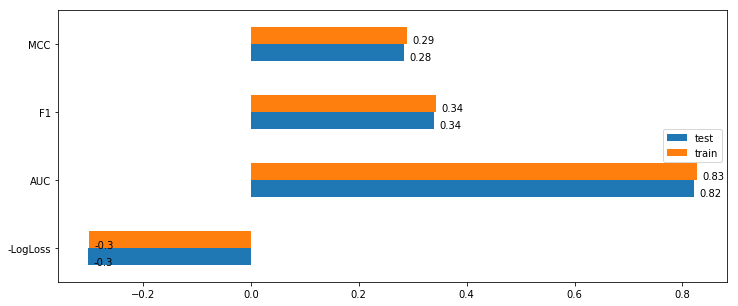

In [127]:
plot_cv_res_df(cv_res_df=gs_gb_res_df, figsize=(12, 5))

In [128]:
t0 = time()
train_sizes_gb, train_scores_gb, test_scores_gb = learning_curve(estimator=gs_gb_best_estim, X=X_test, y=y_test,
                                                                 cv=inner_cv, n_jobs=max_jobs, scoring='roc_auc',
                                                                 train_sizes=np.linspace(0.1, 1.0, 5))
print('Fit Time: ', (time() - t0))

Fit Time:  23.069666862487793


<module 'matplotlib.pyplot' from 'D:\\moneyveo\\mvt\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

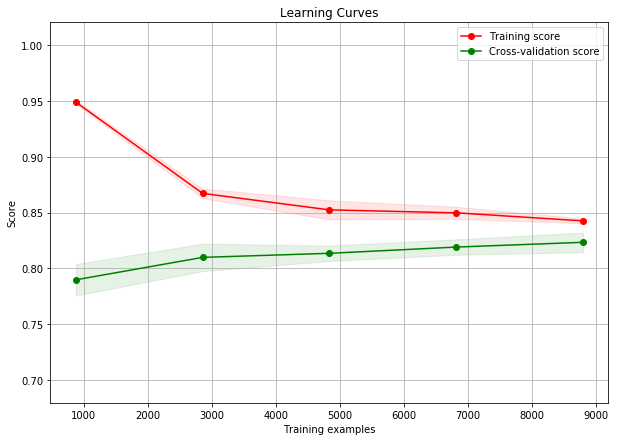

In [129]:
plot_learning_curve(train_sizes=train_sizes_gb, train_scores=train_scores_gb, test_scores=test_scores_gb,
                    title='Learning Curves', ylim=(0.68, 1.02), figsize=(10, 7))

#### REFIT

In [130]:
t0 = time()
gs_gb_best_estim.fit(X_train, y_train)
print('Fit Time: ', (time() - t0))

Fit Time:  28.744826078414917


In [184]:
t0 = time()
gb_pred_train = gs_gb_best_estim.predict(X_train)
gb_pred_test = gs_gb_best_estim.predict(X_test)
gb_proba_train = gs_gb_best_estim.predict_proba(X_train)
gb_proba_test = gs_gb_best_estim.predict_proba(X_test)
print('Predict Time: ', (time() - t0))

Predict Time:  12.16709280014038


In [132]:
print('#TRAIN GB#\nAUC: {}\nF1: {}\nMCC: {}\nKS: D={}, p-value={}\nLog Loss: {}'
      ''.format(roc_auc_score(y_train, gb_proba_train[:, 1]),
                f1_score(y_true=y_train, y_pred=gb_pred_train,
                         pos_label=1, average='binary'),
                matthews_corrcoef(y_train, gb_pred_train),
                ks_2samp(y_train, gb_pred_train)[0],
                ks_2samp(y_train, gb_pred_train)[1],
                log_loss(y_train, gb_proba_train[:, 1]), ))

print('\n#TEST GB#\nAUC: {}\nF1: {}\nMCC: {}\nKS: D={}, p-value={}\nLog Loss: {}'
      ''.format(roc_auc_score(y_test, gb_proba_test[:, 1]),
                f1_score(y_true=y_test, y_pred=gb_pred_test,
                         pos_label=1, average='binary'),
                matthews_corrcoef(y_test, gb_pred_test),
                ks_2samp(y_train, gb_pred_test)[0],
                ks_2samp(y_train, gb_pred_test)[1],
                log_loss(y_test, gb_proba_test[:, 1]), ))

#TRAIN GB#
AUC: 0.8288343635409661
F1: 0.34602451458943484
MCC: 0.2919159375061624
KS: D=0.03253187820913617, p-value=1.015047108935291e-24
Log Loss: 0.2996985170936183

#TEST GB#
AUC: 0.8216124009377698
F1: 0.3337612323491656
MCC: 0.2783289250283113
KS: D=0.03495507635594697, p-value=1.179390094655833e-11
Log Loss: 0.3062009248109335


In [133]:
print(classification_report(y_test, gb_pred_test))

             precision    recall  f1-score   support

          0       0.95      0.92      0.94     12257
          1       0.28      0.42      0.33       938

avg / total       0.91      0.88      0.89     13195



<module 'matplotlib.pyplot' from 'D:\\moneyveo\\mvt\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

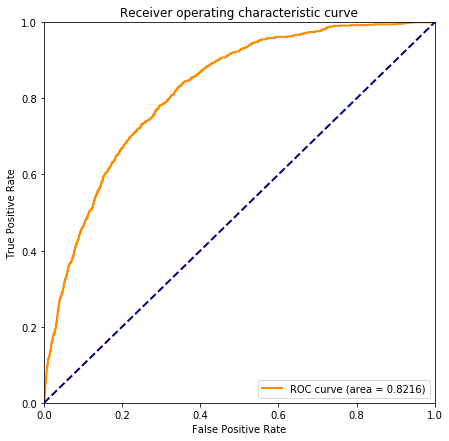

In [134]:
plot_roc_curve(target=y_test, proba=gb_proba_test[:, 1], pos_label=1, figsize=(7, 7))

<module 'matplotlib.pyplot' from 'D:\\moneyveo\\mvt\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

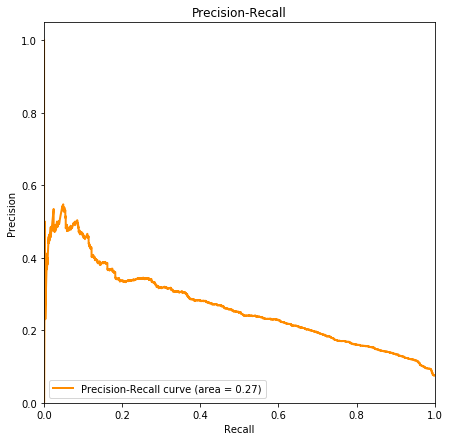

In [135]:
plot_prc_curve(target=y_test, proba=gb_proba_test[:, 1], pos_label=1, average='macro', figsize=(7, 7))

###Calibrate GB

In [178]:
pipe_calib_gb = Pipeline(steps=[('pipe_base', pipe_base),
                                ('smote', SMOTE(ratio='auto',
                                                kind='regular',
                                                n_jobs=max_jobs,
                                                random_state=random_state)),
                                ('gradient_boosting_calibrated', CalibratedClassifierCV(
                                    base_estimator=GradientBoostingClassifier(random_state=random_state,
                                                                              loss='deviance',
                                                                              criterion='friedman_mse',
                                                                              subsample=0.50,
                                                                              presort=True,
                                                                              n_estimators=300,
                                                                              learning_rate=0.1,
                                                                              max_features='sqrt',
                                                                              max_depth=4,
                                                                              min_samples_leaf=0.15,
                                                                              min_impurity_decrease=0.00, ),
                                    cv=8, method='isotonic')),
                                ],
                         # memory='pipe_cache/'
                         )

In [179]:
t0 = time()
pipe_calib_gb.fit(X_train, y_train)
print('Fit Time: ', (time() - t0))

Fit Time:  125.3026852607727


In [185]:
t0 = time()
calib_gb_pred_train = pipe_calib_gb.predict(X_train)
calib_gb_pred_test = pipe_calib_gb.predict(X_test)
calib_gb_proba_train = pipe_calib_gb.predict_proba(X_train)
calib_gb_proba_test = pipe_calib_gb.predict_proba(X_test)
print('Predict Time: ', (time() - t0))

Predict Time:  18.639182090759277


In [186]:
print('#TRAIN GB CALIBRATED#\nAUC: {}\nF1: {}\nMCC: {}\nKS: D={}, p-value={}\nLog Loss: {}'
      ''.format(roc_auc_score(y_train, calib_gb_proba_train[:, 1]),
                f1_score(y_true=y_train, y_pred=calib_gb_pred_train,
                         pos_label=1, average='binary'),
                matthews_corrcoef(y_train, calib_gb_pred_train),
                ks_2samp(y_train, calib_gb_pred_train)[0],
                ks_2samp(y_train, calib_gb_pred_train)[1],
                log_loss(y_train, calib_gb_proba_train[:, 1]), ))

print('\n#TEST GB CALIBRATED#\nAUC: {}\nF1: {}\nMCC: {}\nKS: D={}, p-value={}\nLog Loss: {}'
      ''.format(roc_auc_score(y_test, calib_gb_proba_test[:, 1]),
                f1_score(y_true=y_test, y_pred=calib_gb_pred_test,
                         pos_label=1, average='binary'),
                matthews_corrcoef(y_test, calib_gb_pred_test),
                ks_2samp(y_train, calib_gb_pred_test)[0],
                ks_2samp(y_train, calib_gb_pred_test)[1],
                log_loss(y_test, calib_gb_proba_test[:, 1]), ))

#TRAIN GB CALIBRATED#
AUC: 0.8326871230900934
F1: 0.34087518647439086
MCC: 0.28753589144345804
KS: D=0.010269235870327242, p-value=0.007589031929281702
Log Loss: 0.25093611546121924

#TEST GB CALIBRATED#
AUC: 0.8249734758415755
F1: 0.3298076923076923
MCC: 0.2746216768824226
KS: D=0.015478001706458522, p-value=0.012568873127212629
Log Loss: 0.2620229789779755


In [187]:
print(classification_report(y_test, calib_gb_pred_test))

             precision    recall  f1-score   support

          0       0.95      0.93      0.94     12257
          1       0.30      0.37      0.33       938

avg / total       0.90      0.89      0.90     13195



<module 'matplotlib.pyplot' from 'D:\\moneyveo\\mvt\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

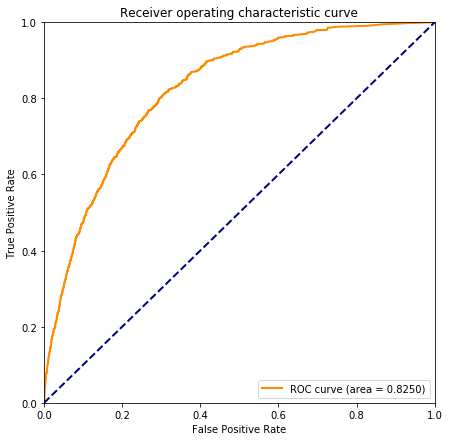

In [188]:
plot_roc_curve(target=y_test, proba=calib_gb_proba_test[:, 1], pos_label=1, figsize=(7, 7))

<module 'matplotlib.pyplot' from 'D:\\moneyveo\\mvt\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

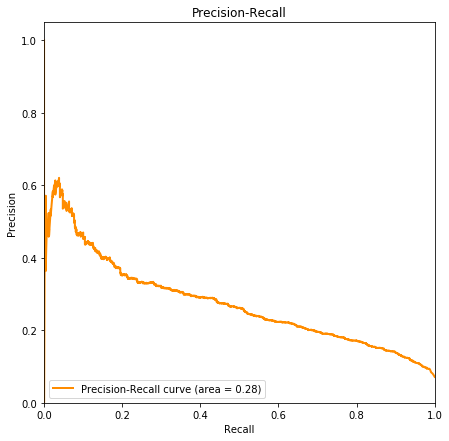

In [189]:
plot_prc_curve(target=y_test, proba=calib_gb_proba_test[:, 1], pos_label=1, average='macro', figsize=(7, 7))

### Plot calibration curves

In [190]:
cc_gb_true_pos, cc_gb_pred_pos = calibration_curve(y_test, gb_proba_test[:, 1], n_bins=10)
cc_calib_gb_true_pos, cc_calib_gb_pred_pos = calibration_curve(y_test, calib_gb_proba_test[:, 1], n_bins=10)

Text(0.5,1,'Calibration curves')

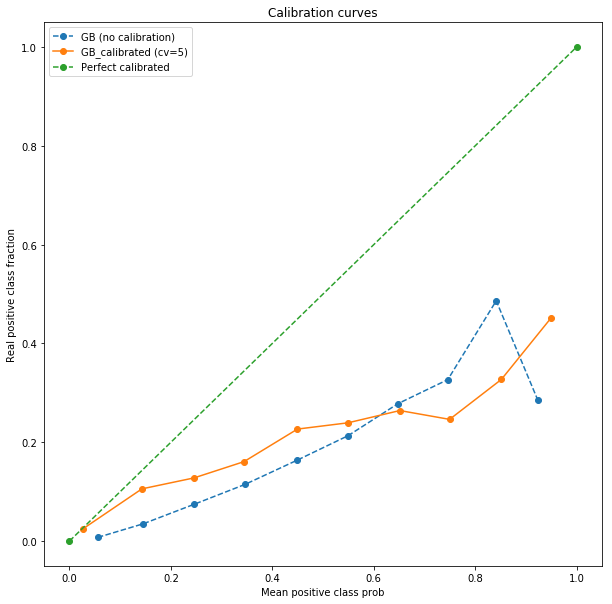

In [191]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
plt.plot(cc_gb_pred_pos, cc_gb_true_pos, '--o', label='GB (no calibration)', axes=ax)
plt.plot(cc_calib_gb_pred_pos, cc_calib_gb_true_pos, '-o', label='GB_calibrated (cv=5)', axes=ax)
plt.plot([0, 1], [0, 1], '--o', label='Perfect calibrated')
ax.set_xlabel('Mean positive class prob')
ax.set_ylabel('Real positive class fraction')
ax.legend(loc='best')
ax.set_title('Calibration curves')